In [1]:
!rm -rf data/
!git clone https://github.com/cse151a-nba-project/data.git

Cloning into 'data'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 19), reused 39 (delta 15), pack-reused 0
Receiving objects: 100% (48/48), 12.00 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np

# 1. Evaluate your (Milestone 4) data, labels and loss function. Were they sufficient or did you have have to change them.

Reference: https://github.com/cse151a-nba-project/milestone-4/blob/main/CSE_151A_Milestone_4.ipynb

After evaluating our data, labels, and loss function for Milestone 4, we believe that they were sufficient and well-suited for our SVR (Support Vector Regression) model. We did not have to make any significant changes to them.

Regarding the data, our decision to use the comprehensive NBA player and team performance dataset from 1990-2023 has proven to be effective. This dataset provides a wealth of information that captures the performance of players and teams over a substantial period. We believe that using data from this specific range strikes a good balance between having enough data points to train our model effectively and avoiding the inclusion of unrepresentative data from earlier eras, where the game and player dynamics might have been significantly different. Increasing the year range further into the past could introduce noise and hinder the model's ability to capture relevant patterns, while decreasing the year range might result in insufficient data and potential overfitting.

In terms of labels, our selection of features such as 'ts_percent', 'experience', 'x3p_ar', 'per', 'ws_48', 'usg_percent', 'bpm', and 'vorp' has provided a comprehensive representation of player and team performance. These labels encompass various aspects of the game, including shooting efficiency, player experience, three-point attempt rate, player efficiency rating, win shares per 48 minutes, usage percentage, box plus-minus, and value over replacement player. By incorporating these diverse metrics, we can capture the multi-faceted nature of player contributions and their impact on team success. The combination of these labels has proven to be informative and relevant for predicting team win percentages.

Moreover, our decision to consider the top 10 players in every NBA team has been effective in capturing the core contributors to team performance. By focusing on the top 10 players, we ensure that we are accounting for the most impactful players who receive significant playing time and have a substantial influence on the team's success. This approach allows us to capture the essential information while managing the dimensionality of the data, preventing issues related to sparsity or irrelevant data points.

Regarding the loss function, it is important to note that since we are using an SVR model, we do not rely on the same loss functions typically used in deep neural networks (DNNs) or linear regression models. SVR uses a different optimization objective and employs the concept of margin-based loss, specifically the epsilon-insensitive loss function. This loss function is designed to find a hyperplane that fits the data within a specified margin while allowing for some tolerance for errors. The goal is to minimize the margin violation and find a balance between fitting the training data and generalizing well to unseen data.

Furthermore, the choice of kernel function in SVR, such as the radial basis function (RBF) kernel, allows us to capture non-linear relationships between the features and the target variable. This is particularly useful in our case, as the relationship between player statistics and team win percentages may not always be linear. The kernel function implicitly maps the input features into a higher-dimensional space, enabling the model to find complex patterns and make more accurate predictions.

In conclusion, after thorough evaluation, we believe that our data, labels, and loss function were sufficient and appropriate for our SVR model. The comprehensive NBA player and team performance dataset from 1990-2023, along with the selected labels and the focus on the top 10 players in each team, provides a robust foundation for training our model. The epsilon-insensitive loss function used in SVR is well-suited for our regression task and allows for flexibility in handling noise and outliers. Therefore, we did not find it necessary to make significant changes to our data, labels, or loss function for Milestone 4.


#Milestone 4 code, needed for model building in this milestone

In [4]:
TOP_X_PLAYERS = 10
INPUT_STATS = ['ts_percent', 'experience', 'x3p_ar', 'per', 'ws_48', 'usg_percent', 'bpm', 'vorp']
INPUT_FEATURE_COUNT = TOP_X_PLAYERS * (len(INPUT_STATS) + 1)
START_YEAR = 1990
END_YEAR = 2023

"""
Extract raw stats of top players in a given year (for either a specific team or all teams).
Uses Advanced.csv file and extracts INPUT_STATS fields.

Output: A tuple containing two elements:
corresp_team_win: A list of (actual) win percentages for the teams included in the analysis.
  (y value that we're trying to predict with our models)
top_list_stats: A NumPy array containing the raw numerical values for the advanced statistics for the top players
of the teams included in the analysis, optionally reshaped based on the INPUT_FEATURE_COUNT for model training.
Without reshaping, it is in the shape of (total teams in year, TOP_X_PLAYERS, INPUT_STATS). Reshaped is (year, INPUT_FEATURE_COUNT).
  (x value that we're using to predict y in our models)
"""
def top_from_team(year, reshape=True, input_team=None):
  advanced_player_data = pd.read_csv("data/Advanced.csv")
  team_data = pd.read_csv("data/Team Summaries.csv")
  team_data = team_data[team_data['season'] == year]
  player_data = pd.read_csv("data/Player Per Game.csv")
  player_data = player_data[player_data['season'] == year]
  top = player_data.sort_values(['tm', 'mp_per_game'], ascending=[True, False])
  teams = top['tm'].unique()

  if (input_team is not None):
    teams = teams[teams == input_team]
    top = top[top['tm'] == input_team]
  else:
    teams = teams[teams != 'TOT']
    top = top[top['tm'] != 'TOT']

  # make a list of the top players from each team, separated by team name
  top_list = []
  top_list_stats = []
  corresp_team_win = []
  i = 0
  for team in teams:

      # get top players
      top_list.append(top[top['tm'] == team].head(TOP_X_PLAYERS)[['seas_id', 'player_id', 'player', 'pos', 'tm', 'mp_per_game']])

      top_list_stats.append(None)

      # calculate win percentage
      temp_team_stats = team_data[team_data['abbreviation'] == team]
      corresp_team_win.append(100 * float(temp_team_stats['w']) / (float(temp_team_stats['w']) + float(temp_team_stats['l'])))

      # do an advanced stats look up for players
      for index, player in top_list[i].iterrows():
        indiv_player_stats = advanced_player_data[advanced_player_data['seas_id'] == player['seas_id']][INPUT_STATS].copy()
        indiv_player_stats['mp_per_game'] = player['mp_per_game']
        indiv_player_stats = indiv_player_stats.to_numpy()
        if (top_list_stats[i] is None):
          top_list_stats[i] = indiv_player_stats
        else:
          top_list_stats[i] = np.concatenate((top_list_stats[i], indiv_player_stats))

      i = i + 1
  top_list_stats = np.array(top_list_stats)
  if (reshape):
    top_list_stats = top_list_stats.reshape(-1, INPUT_FEATURE_COUNT)
  return corresp_team_win, top_list_stats

In [5]:
all_data_y = None
all_data_x = None

# combining data
for i in range(START_YEAR, END_YEAR + 1):
  # win perc is y, top team players stats is x
  data_y, data_x = top_from_team(i)
  # don't concatenate if empty
  if (all_data_y is None):
    all_data_y = data_y
    all_data_x = data_x
    continue
  all_data_y = np.concatenate((all_data_y, data_y))
  all_data_x = np.concatenate((all_data_x, data_x))

In [6]:
print(all_data_x.shape)
print(all_data_y.shape)

(993, 90)
(993,)


# Milestone 3 and 4 models, for reference

## Original linear regression model, for reference

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(all_data_x, all_data_y, test_size = 0.2, random_state=21)

regressor = LinearRegression().fit(X_train, y_train)

## Hyperparameter-tuned elastic net model

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaled_all_data_x = scaler_x.fit_transform(all_data_x)

scaler_y = MinMaxScaler()
scaled_all_data_y = scaler_y.fit_transform(all_data_y.reshape(-1, 1))  # Reshape if necessary

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_all_data_x, scaled_all_data_y, test_size=0.2, random_state=21)

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline

elastic_net_model = make_pipeline(MinMaxScaler(), ElasticNet(random_state=21))

# Parameters grid to search for best parameters
# param_grid = {
#     'elasticnet__alpha': [0.1, 0.5, 1, 5, 10], # Regularization strength
#     'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1] # Mix ratio between Lasso and Ridge, 1 is Lasso, 0 is Ridge
# }
param_grid = {
    'elasticnet__alpha': np.linspace(0.001, 0.02, num=20),
    'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1] # Mix ratio between Lasso and Ridge, 1 is Lasso, 0 is Ridge
}

# Grid search to find best parameters
grid_search = GridSearchCV(elastic_net_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_parameters)

Best parameters found:  {'elasticnet__alpha': 0.004, 'elasticnet__l1_ratio': 0.9}


In [10]:
# Best parameters from GridSearchCV
best_alpha = best_parameters['elasticnet__alpha']
best_l1_ratio = best_parameters['elasticnet__l1_ratio']

# Setting up the ElasticNet regressor with the best parameters
elastic_net_regressor = make_pipeline(MinMaxScaler(), ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=21))

# Training the regressor with your training data
elastic_net_regressor.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.004, l1_ratio=0.9, random_state=21))])

## Hyperparameter-tuned DNN model

In [11]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, KFold
from scikeras.wrappers import KerasRegressor

# Define the model function
def create_model(hidden_layers, initial_units, activation):
    model = Sequential()
    model.add(Dense(initial_units, input_dim=X_train.shape[1], activation=activation,
                    kernel_regularizer=l1_l2(0.001)))
    units = initial_units
    for _ in range(hidden_layers - 1):
        units //= 3
        model.add(Dense(units, activation=activation,
                        kernel_regularizer=l1_l2(0.001)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

# Define the hyperparameters to tune
param_grid = {
    'model__hidden_layers': [3, 4, 5, 6],
    'model__initial_units': [30, 90, 270, 810],
    'model__activation': ['relu', 'tanh'],
    'batch_size': [8, 32]
}

# Create the model wrapper
model = KerasRegressor(model=create_model)

# Define the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True),
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Retrieve the best model
best_dnn_model = grid_search.best_estimator_

# Set early stopping callback
early_stopping = EarlyStopping(monitor='val_mse', patience=25, restore_best_weights=True)

# Fit the best model with early stopping
history = best_dnn_model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[early_stopping], verbose=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


100/100 [==============================] - 3s 11ms/step - loss: 216.3127 - mse: 203.4088
Best parameters found:  {'batch_size': 8, 'model__activation': 'relu', 'model__hidden_layers': 3, 'model__initial_units': 810}
Best score:  53.41249009180191


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get model stats
y_test_pred = best_dnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Hyperparameter-tuned Best DNN Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Hyperparameter-tuned Best DNN Model Testing MAE (Mean Absolute Error): {mae}')

25/25 [==============================] - 0s 2ms/step
Hyperparameter-tuned Best DNN Model Testing MSE: 35.98478212444837
Hyperparameter-tuned Best DNN Model Testing MAE (Mean Absolute Error): 4.782714513161879


## A manually tuned DNN model (to show training vs test error)

In [13]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

# Define the model
manual_dnn_model = Sequential([
    Dense(270, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(0.001)),  # First hidden layer with regularization
    Dense(90, activation='relu', kernel_regularizer=l1_l2(0.001)),
    Dense(30, activation='relu', kernel_regularizer=l1_l2(0.001)),  # Second hidden layer with regularization
    Dense(1, activation='linear')  # Output layer for regression
])


# Compile the model
manual_dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Fit the manually tuned model
history = manual_dnn_model.fit(X_train, y_train, epochs=500, batch_size=8, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
80/80 [==============================] - 2s 9ms/step - loss: 296.2467 - mse: 291.0410 - val_loss: 116.4108 - val_mse: 112.0471
Epoch 2/500
80/80 [==============================] - 0s 5ms/step - loss: 75.9891 - mse: 71.8531 - val_loss: 70.2390 - val_mse: 66.2066
Epoch 3/500
80/80 [==============================] - 0s 6ms/step - loss: 54.1288 - mse: 50.1280 - val_loss: 42.9230 - val_mse: 38.9533
Epoch 4/500
80/80 [==============================] - 0s 6ms/step - loss: 44.1026 - mse: 40.1516 - val_loss: 38.6776 - val_mse: 34.7551
Epoch 5/500
80/80 [==============================] - 0s 6ms/step - loss: 39.7317 - mse: 35.8352 - val_loss: 35.3283 - val_mse: 31.4559
Epoch 6/500
80/80 [==============================] - 0s 4ms/step - loss: 38.5557 - mse: 34.7011 - val_loss: 36.8019 - val_mse: 32.9708
Epoch 7/500
80/80 [==============================] - 0s 3ms/step - loss: 35.1567 - mse: 31.3439 - val_loss: 40.8939 - val_mse: 37.1044
Epoch 8/500
80/80 [==============================] 

###DNN model training history visualization

7/7 [==============================] - 0s 2ms/step
Manual DNN Model Testing MSE: 23.58810066635914
Manual DNN Model Testing MAE (Mean Absolute Error): 4.021471835883596


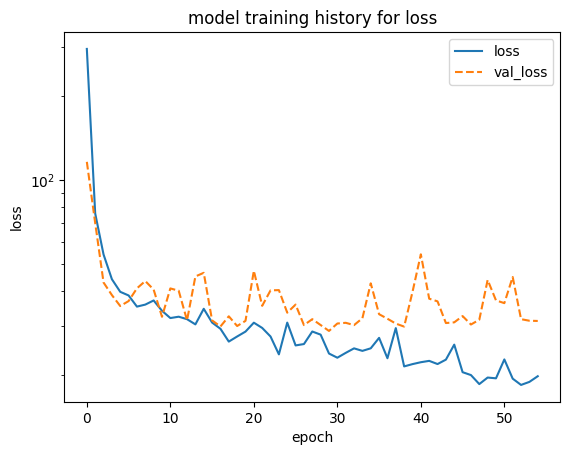

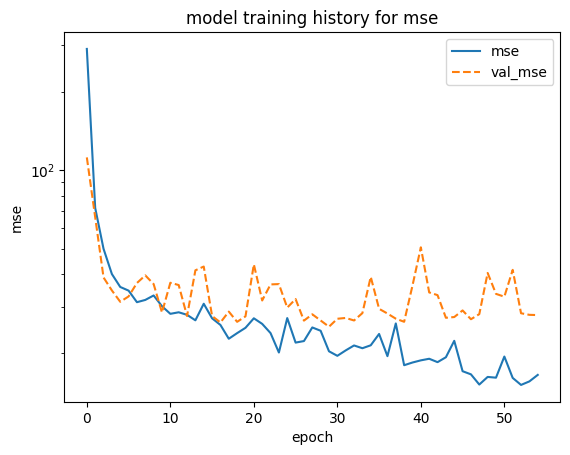

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get model stats and visualize them
y_test_pred = manual_dnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Manual DNN Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Manual DNN Model Testing MAE (Mean Absolute Error): {mae}')

metrics = ['loss', 'mse']
for key in metrics:
  plt.figure()
  plt.plot(history.history[key], label=key)
  plt.plot(history.history['val_' + key], '--', label='val_' + key)
  plt.title('model training history for ' + key)
  plt.ylabel(key)
  plt.yscale('log')
  plt.xlabel('epoch')
  plt.legend()


#2. Train your third model

We decided to train a SVR (Support Vector Regression) model for this final milestone. We thought this would be a new perspective on the problem since SVR is a powerful and versatile algorithm that can handle non-linear relationships between features and the target variable. Unlike our previous models, such as linear regression and neural networks, SVR has the ability to capture more complex patterns in the data by mapping the input features into a higher-dimensional space using kernel functions. See code, results, and further analysis below.

In [15]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR

# Define the hyperparameters to tune
param_grid = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1],
    'gamma': ['scale', 'auto'] + list(np.logspace(-2, 2, 4)),
    'degree': [2, 3, 4]
}

# Create the SVR model
model = SVR()

# Define the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Retrieve the best model
best_svr_model = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'poly'}
Best score:  28.814648293232956


In [16]:
# Fit the best model
best_svr_model.fit(X_train, y_train)

SVR(C=0.1, degree=2, epsilon=0.01, gamma=0.01, kernel='poly')

## Ensemble model

In [46]:
def ensemble_predict(X):
  ensemble_models = {
    'Elastic net model': elastic_net_regressor,
    'Linear regression model': regressor,
    'Manual DNN': manual_dnn_model,
    'HP-Tuned DNN': best_model,
    'SVR Model': best_svr_model
  }
  overall_prediction = None
  for model_name, model in models.items():
    prediction = model.predict(X).flatten()
    if (overall_prediction is None):
      overall_prediction = prediction
    else:
      overall_prediction += prediction
  return overall_prediction / len(models.items())

#3. Evaluate your model compare training vs test error

##Milestone 3 linear regression model performance, for reference

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 16.704562823490082
Model Training MAE (Mean Absolute Error): 3.2729839541334536
Model Training R^2 (Coeff of Deter.): 0.9312136253734027


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 20.881715559452186
Model Testing MAE (Mean Absolute Error): 3.7103901502672767
Model Testing R^2 (Coeff of Deter.): 0.902803293612228


## Milestone 4 Elastic net model performance, for reference

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = elastic_net_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 17.376403585173943
Model Training MAE (Mean Absolute Error): 3.3292256792705097
Model Training R^2 (Coeff of Deter.): 0.9284471063803035


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = elastic_net_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 19.921889857702606
Model Testing MAE (Mean Absolute Error): 3.6713894598611754
Model Testing R^2 (Coeff of Deter.): 0.907270929264614


## Milestone 4 Hyperparameter-tuned DNN model performance, for reference

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = best_dnn_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

100/100 [==============================] - 0s 3ms/step
Model Training MSE: 9.186167069540218
Model Training MAE (Mean Absolute Error): 1.9511265369911468
Model Training R^2 (Coeff of Deter.): 0.9621730220596169


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = best_dnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

25/25 [==============================] - 0s 3ms/step
Model Testing MSE: 35.98478212444837
Model Testing MAE (Mean Absolute Error): 4.782714513161879
Model Testing R^2 (Coeff of Deter.): 0.8325040731150678


## Milestone 4 Manually tuned DNN model performance, for reference

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = manual_dnn_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

25/25 [==============================] - 0s 2ms/step
Model Training MSE: 18.80603285668206
Model Training MAE (Mean Absolute Error): 3.396779448706997
Model Training R^2 (Coeff of Deter.): 0.9225601510803527


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = manual_dnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

7/7 [==============================] - 0s 2ms/step
Model Testing MSE: 23.58810066635914
Model Testing MAE (Mean Absolute Error): 4.021471835883596
Model Testing R^2 (Coeff of Deter.): 0.8902060662503601


## Milestone 5 SVR model performance

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = best_svr_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 12.083172892671065
Model Training MAE (Mean Absolute Error): 2.1339200508272604
Model Training R^2 (Coeff of Deter.): 0.9502436749733769


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = best_svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 25.280907743815813
Model Testing MAE (Mean Absolute Error): 4.168137412146975
Model Testing R^2 (Coeff of Deter.): 0.8823266718581584


## Milestone 5 Ensemble model performance

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = ensemble_predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

25/25 [==============================] - 0s 2ms/step
Model Training MSE: 14.802741425768348
Model Training MAE (Mean Absolute Error): 2.995420414180162
Model Training R^2 (Coeff of Deter.): 0.9390449826210528


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = ensemble_predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

7/7 [==============================] - 0s 3ms/step
Model Testing MSE: 19.634257839666727
Model Testing MAE (Mean Absolute Error): 3.6801779171675597
Model Testing R^2 (Coeff of Deter.): 0.9086097505278938


## Visualization: Team Win Percentage Distribution (Predicted vs. Acutal)

Elastic net model 2000 MSE: 16.61714609398939
Linear regression model 2000 MSE: 16.01094913155602
1/1 [==============================] - 0s 20ms/step
Manual DNN 2000 MSE: 15.0480469467172
SVR Model 2000 MSE: 8.61785129984292


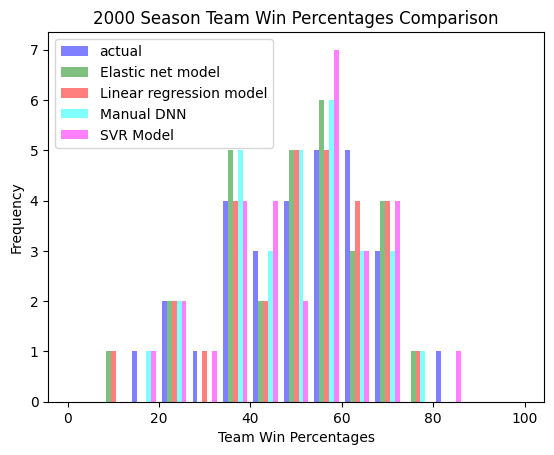

Elastic net model 2004 MSE: 9.658103213283072
Linear regression model 2004 MSE: 11.001768117992187
1/1 [==============================] - 0s 22ms/step
Manual DNN 2004 MSE: 15.132983664708016
SVR Model 2004 MSE: 10.074150661337061


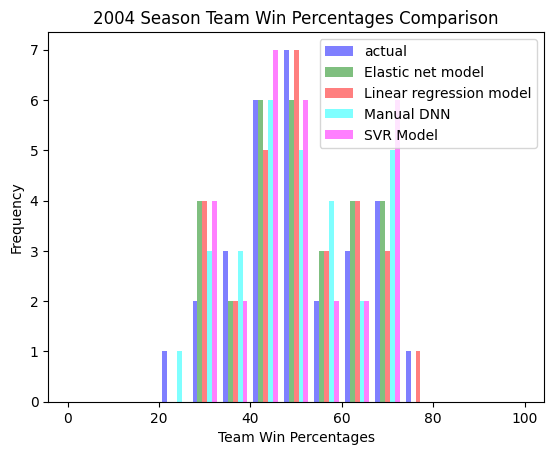

Elastic net model 2008 MSE: 13.674531310080596
Linear regression model 2008 MSE: 14.068617893002388
1/1 [==============================] - 0s 21ms/step
Manual DNN 2008 MSE: 13.037608238298798
SVR Model 2008 MSE: 9.143392875160403


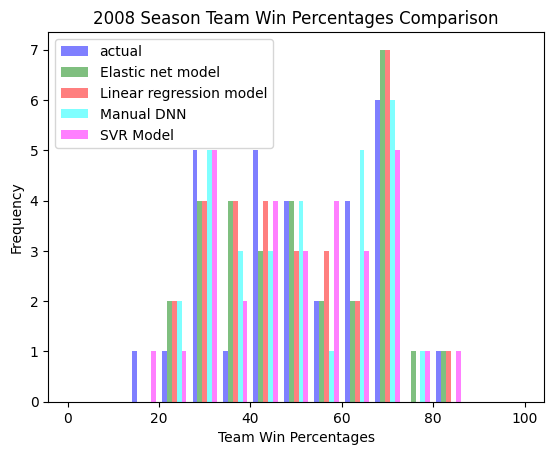

Elastic net model 2012 MSE: 16.081028413380626
Linear regression model 2012 MSE: 15.950830632909698
1/1 [==============================] - 0s 19ms/step
Manual DNN 2012 MSE: 24.542615206686353
SVR Model 2012 MSE: 21.945919591494388


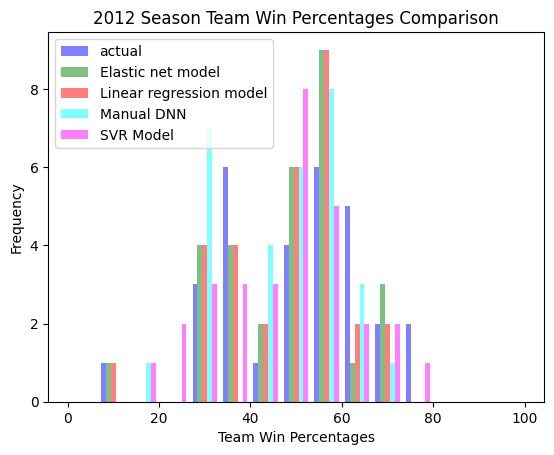

Elastic net model 2016 MSE: 13.399156478368003
Linear regression model 2016 MSE: 15.245535825122204
1/1 [==============================] - 0s 22ms/step
Manual DNN 2016 MSE: 19.310799762418462
SVR Model 2016 MSE: 9.696344555323211


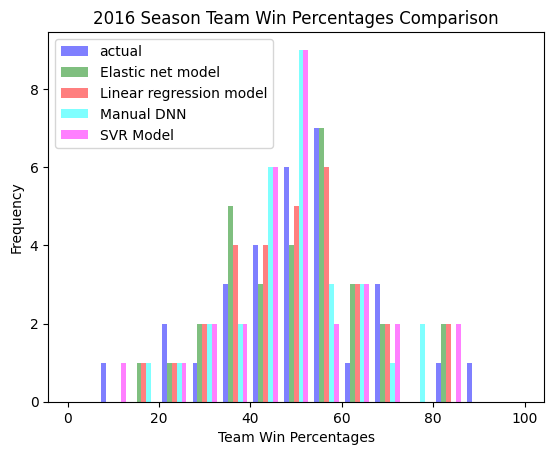

Elastic net model 2020 MSE: 22.842012243628936
Linear regression model 2020 MSE: 22.089408105904145
1/1 [==============================] - 0s 21ms/step
Manual DNN 2020 MSE: 30.905185440486743
SVR Model 2020 MSE: 17.325453582392456


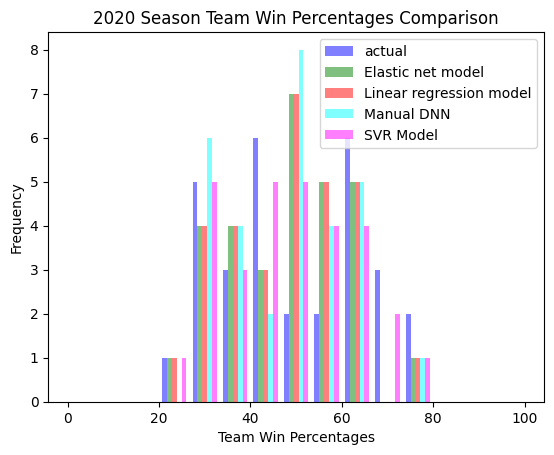

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_win_dist_predict_vs_actual(year, models):
    year_win, year_stats = top_from_team(year)  # Assuming this fetches actual win percentages and stats for the year

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # Extend as needed
    color_index = 0
    predictions = [year_win]

    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        mse = mean_squared_error(year_win, year_predicted)
        predictions.append(year_predicted)
        print(f'{model_name} {year} MSE: {mse}')

    # Plot predicted win percentages for each model
    plt.hist(predictions, range=[0, 100], alpha=0.5, bins=15, label=['actual'] + list(models.keys()), color=colors[:len(predictions)])

    plt.legend(loc='best')
    plt.xlabel('Team Win Percentages')
    plt.ylabel('Frequency')
    plt.title(f'{year} Season Team Win Percentages Comparison')

    # Display the plot
    plt.show()

def plot_win_dist_predict_vs_actual_plots(models):
    START_YEAR = 2000
    END_YEAR = 2020

    for i in range(START_YEAR, END_YEAR + 1, 4):
        plot_win_dist_predict_vs_actual(i, models)

plot_win_dist_predict_vs_actual_plots({'Elastic net model': elastic_net_regressor, 'Linear regression model': regressor, 'Manual DNN': manual_dnn_model, 'SVR Model': best_svr_model})

## Visualization: Team Percentage Residual Error  (Predicted vs. Acutal)

Elastic net model 2000 Actual vs. Predicted MSE: 16.61714609398939
Linear regression model 2000 Actual vs. Predicted MSE: 16.01094913155602
1/1 [==============================] - 0s 21ms/step
Manual DNN 2000 Actual vs. Predicted MSE: 15.0480469467172
SVR Model 2000 Actual vs. Predicted MSE: 8.61785129984292
1/1 [==============================] - 0s 21ms/step
Average prediction MSE: 12.40525289898398


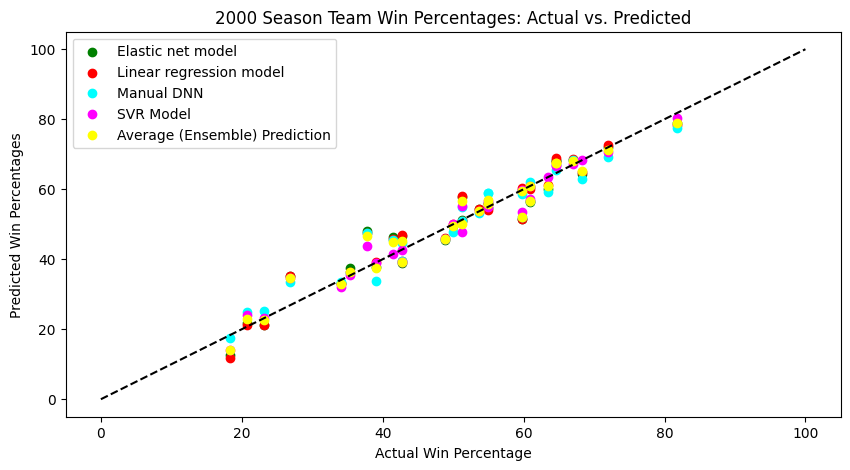

Elastic net model 2000 Error Mean: 0.24006533764208235 Error Standard Dev: 4.069338364851488
Linear regression model 2000 Error Mean: 0.2795658964289968 Error Standard Dev: 3.991590164472033
1/1 [==============================] - 0s 21ms/step
Manual DNN 2000 Error Mean: 0.029720766790981706 Error Standard Dev: 3.8790673650683813
SVR Model 2000 Error Mean: -0.06637073094167324 Error Standard Dev: 2.9348673267998313


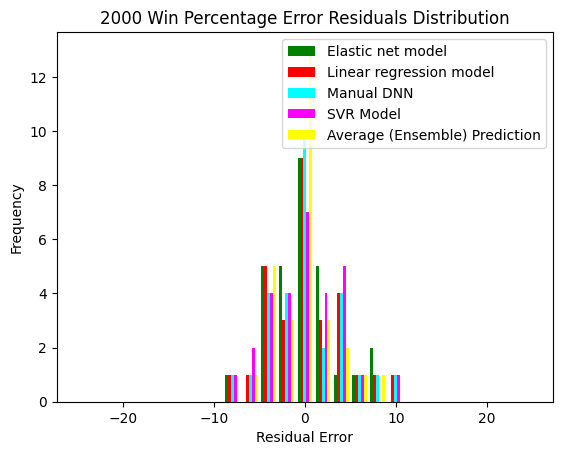

Elastic net model 2004 Actual vs. Predicted MSE: 9.658103213283072
Linear regression model 2004 Actual vs. Predicted MSE: 11.001768117992187
1/1 [==============================] - 0s 23ms/step
Manual DNN 2004 Actual vs. Predicted MSE: 15.132983664708016
SVR Model 2004 Actual vs. Predicted MSE: 10.074150661337061
1/1 [==============================] - 0s 22ms/step
Average prediction MSE: 9.34125057931335


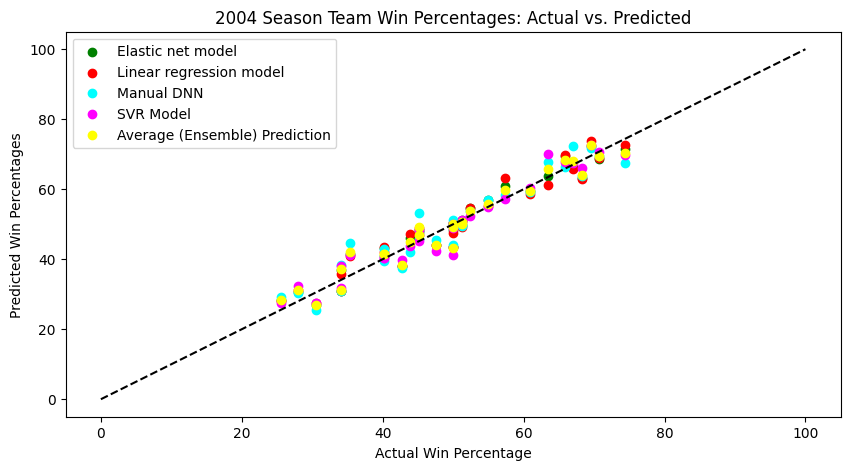

Elastic net model 2004 Error Mean: 0.15713671224761927 Error Standard Dev: 3.103773713875914
Linear regression model 2004 Error Mean: 0.11711774459091127 Error Standard Dev: 3.3148230046103704
1/1 [==============================] - 0s 33ms/step
Manual DNN 2004 Error Mean: 0.239131730178306 Error Standard Dev: 3.8827567114525663
SVR Model 2004 Error Mean: 0.006829250631512353 Error Standard Dev: 3.1739729083079573


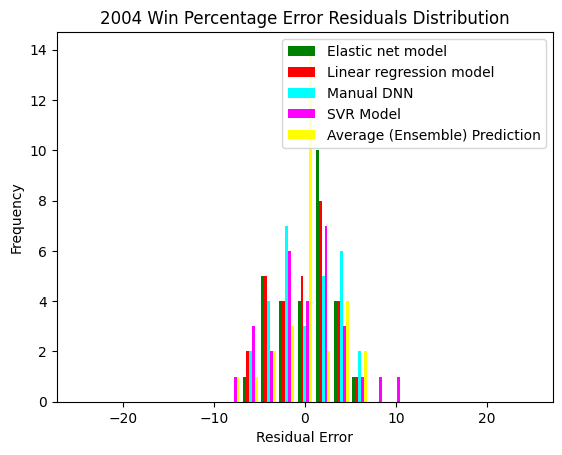

Elastic net model 2008 Actual vs. Predicted MSE: 13.674531310080596
Linear regression model 2008 Actual vs. Predicted MSE: 14.068617893002388
1/1 [==============================] - 0s 23ms/step
Manual DNN 2008 Actual vs. Predicted MSE: 13.037608238298798
SVR Model 2008 Actual vs. Predicted MSE: 9.143392875160403
1/1 [==============================] - 0s 21ms/step
Average prediction MSE: 10.996002001520017


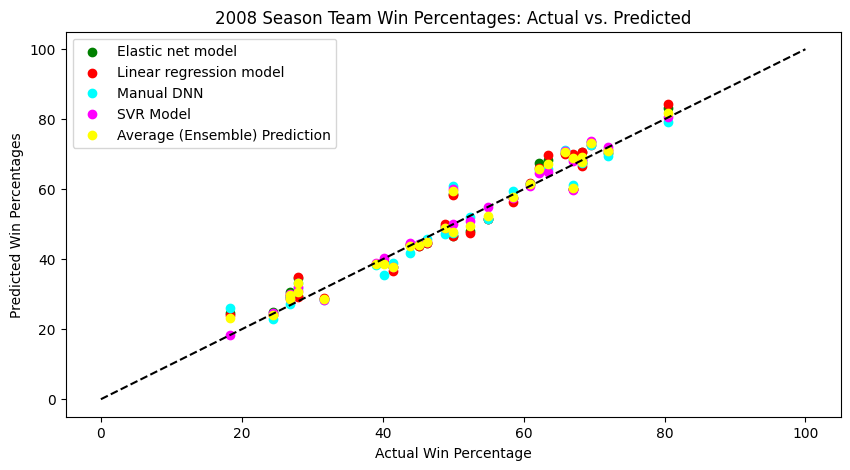

Elastic net model 2008 Error Mean: 0.8028787011677954 Error Standard Dev: 3.6096976467969872
Linear regression model 2008 Error Mean: 0.6982990998961939 Error Standard Dev: 3.68524032596065
1/1 [==============================] - 0s 21ms/step
Manual DNN 2008 Error Mean: 0.4382074356079094 Error Standard Dev: 3.5840734481420355
SVR Model 2008 Error Mean: 0.6110100335049216 Error Standard Dev: 2.9614286441035036


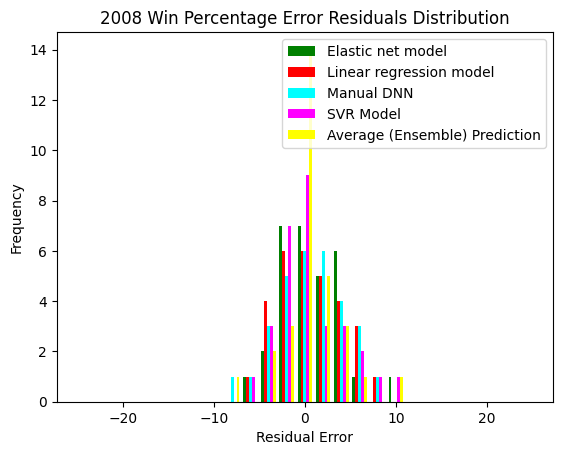

Elastic net model 2012 Actual vs. Predicted MSE: 16.081028413380626
Linear regression model 2012 Actual vs. Predicted MSE: 15.950830632909698
1/1 [==============================] - 0s 22ms/step
Manual DNN 2012 Actual vs. Predicted MSE: 24.542615206686353
SVR Model 2012 Actual vs. Predicted MSE: 21.945919591494388
1/1 [==============================] - 0s 31ms/step
Average prediction MSE: 17.227477075431953


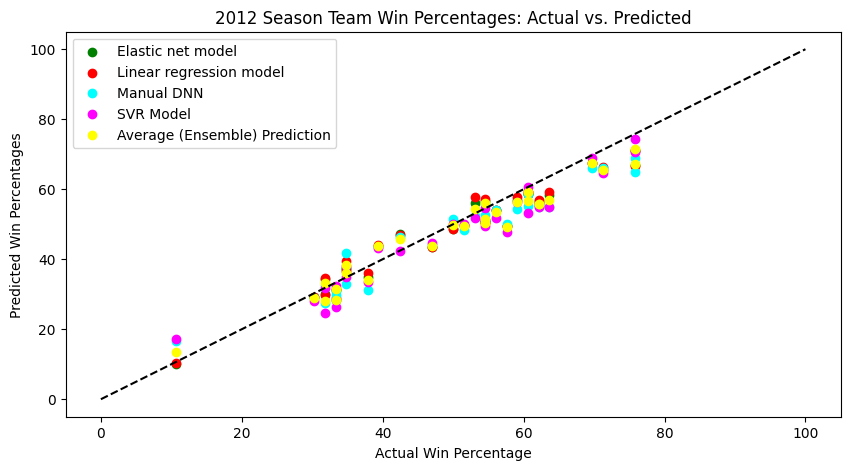

Elastic net model 2012 Error Mean: -2.0105559942354203 Error Standard Dev: 3.469681974968981
Linear regression model 2012 Error Mean: -1.7094153854876784 Error Standard Dev: 3.6095331654893705
1/1 [==============================] - 0s 22ms/step
Manual DNN 2012 Error Mean: -2.634831428527832 Error Standard Dev: 4.19526859091624
SVR Model 2012 Error Mean: -2.726999206987007 Error Standard Dev: 3.8091199661584074


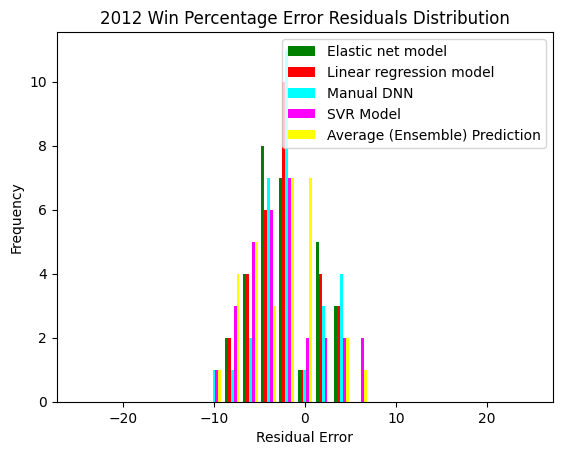

Elastic net model 2016 Actual vs. Predicted MSE: 13.399156478368003
Linear regression model 2016 Actual vs. Predicted MSE: 15.245535825122204
1/1 [==============================] - 0s 21ms/step
Manual DNN 2016 Actual vs. Predicted MSE: 19.310799762418462
SVR Model 2016 Actual vs. Predicted MSE: 9.696344555323211
1/1 [==============================] - 0s 22ms/step
Average prediction MSE: 12.413131347106797


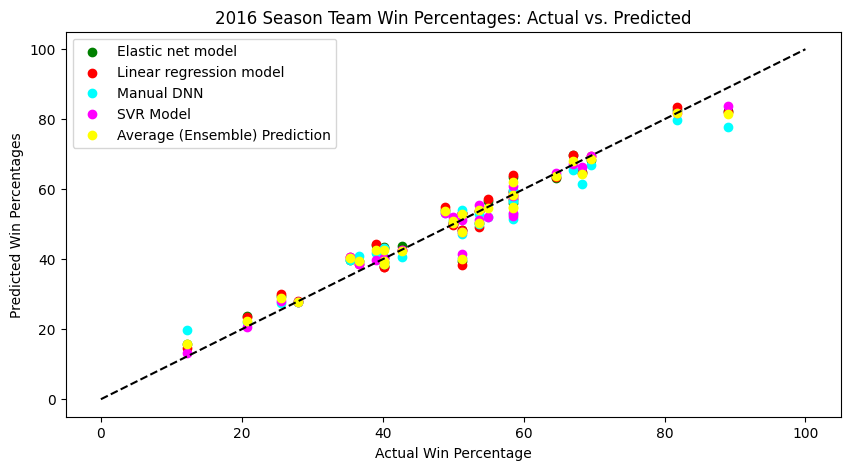

Elastic net model 2016 Error Mean: 0.25120364403195233 Error Standard Dev: 3.6518561318311913
Linear regression model 2016 Error Mean: 0.29384586049205846 Error Standard Dev: 3.893480504046975
1/1 [==============================] - 0s 21ms/step
Manual DNN 2016 Error Mean: -0.9601071675618494 Error Standard Dev: 4.288239031259199
SVR Model 2016 Error Mean: -0.511541280786865 Error Standard Dev: 3.071590805002214


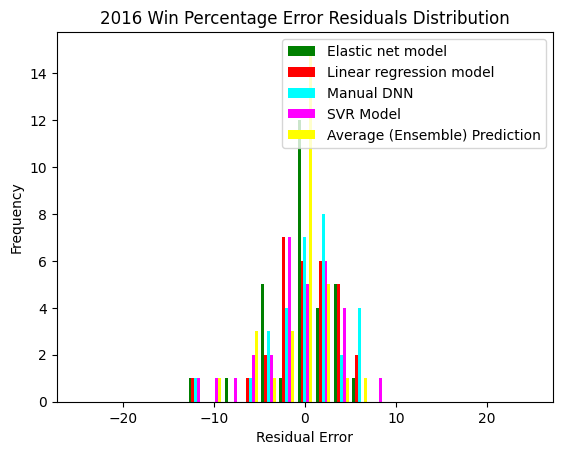

Elastic net model 2020 Actual vs. Predicted MSE: 22.842012243628936
Linear regression model 2020 Actual vs. Predicted MSE: 22.089408105904145
1/1 [==============================] - 0s 22ms/step
Manual DNN 2020 Actual vs. Predicted MSE: 30.905185440486743
SVR Model 2020 Actual vs. Predicted MSE: 17.325453582392456
1/1 [==============================] - 0s 21ms/step
Average prediction MSE: 21.348294222227366


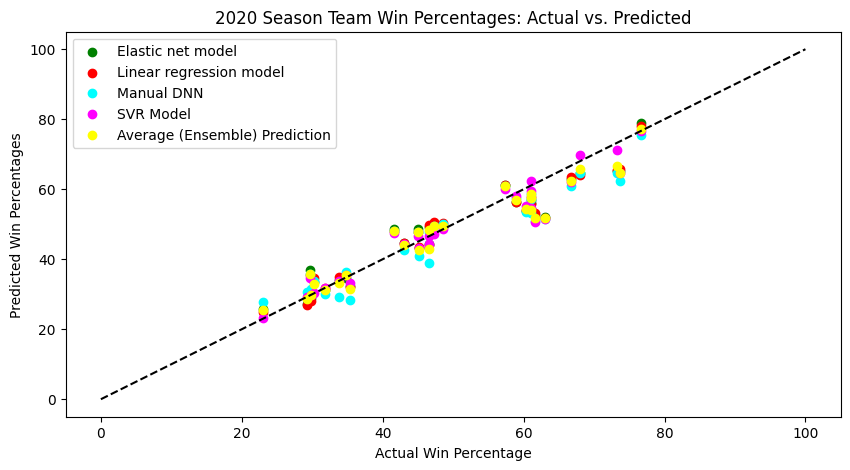

Elastic net model 2020 Error Mean: -1.3886107072106877 Error Standard Dev: 4.573157831023195
Linear regression model 2020 Error Mean: -1.3346907544857076 Error Standard Dev: 4.506440801319209
1/1 [==============================] - 0s 22ms/step
Manual DNN 2020 Error Mean: -2.156492157283777 Error Standard Dev: 5.123936671745691
SVR Model 2020 Error Mean: -1.2887670899025643 Error Standard Dev: 3.957844485370355


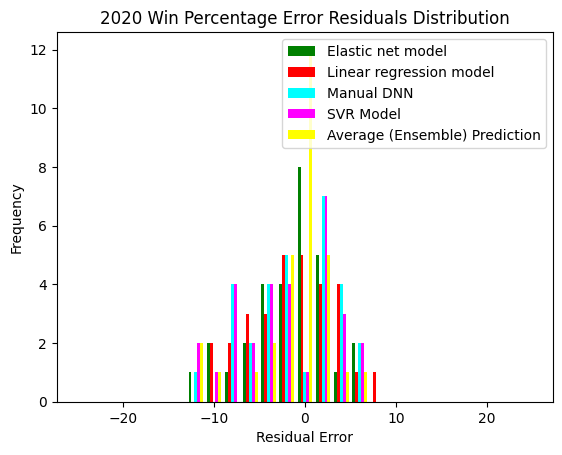

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_win_perc_residuals_predict_vs_actual(year, models):
    year_win, year_stats = top_from_team(year)  # Fetch actual win percentages and stats for the year

    plt.figure(figsize=(10, 5))  # Increase figure size for clarity

    # Plot actual win percentages once for comparison
    # plt.scatter(np.linspace(0, len(year_win), num=len(year_win)), year_win, color="skyblue", label="actual")

    colors = ['green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # Extend as needed for models
    color_index = 0

    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        mse = mean_squared_error(year_win, year_predicted)
        print(f'{model_name} {year} Actual vs. Predicted MSE: {mse}')

        # Plot predicted win percentages for each model
        plt.scatter(year_win, year_predicted, color=colors[color_index], label=model_name)
        color_index += 1

    prediction_average = ensemble_predict(year_stats)
    prediction_mse = mean_squared_error(year_win, prediction_average)
    print(f'Average prediction MSE: {prediction_mse}')
    plt.scatter(year_win, prediction_average, color=colors[color_index], label='Average (Ensemble) Prediction')
    plt.legend(loc='best')
    plt.xlabel('Actual Win Percentage')
    plt.ylabel('Predicted Win Percentages')
    plt.title(f'{year} Season Team Win Percentages: Actual vs. Predicted')
    identity_line = np.linspace(0,100)
    plt.plot(identity_line, identity_line, color="black", linestyle="dashed")
    plt.show()

    all_residuals = [np.array(prediction_average) - np.array(year_win)]
    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        error = np.array(year_predicted) - np.array(year_win)
        all_residuals.append(error)
        print(f'{model_name} {year} Error Mean: {np.mean(error)} Error Standard Dev: {np.std(error)}')

    plt.hist(all_residuals, color=colors[:len(models.keys()) + 1], bins=25, range=[-25, 25], label=list(models.keys()) + ['Average (Ensemble) Prediction'])
    plt.legend(loc='best')
    plt.title(f'{year} Win Percentage Error Residuals Distribution')
    plt.xlabel('Residual Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_win_perc_residuals_predict_vs_actual_plots(models):
    START_YEAR = 2000
    END_YEAR = 2020

    for i in range(START_YEAR, END_YEAR + 1, 4):
        plot_win_perc_residuals_predict_vs_actual(i, models)

plot_win_perc_residuals_predict_vs_actual_plots({ 'Elastic net model': elastic_net_regressor, 'Linear regression model': regressor, 'Manual DNN': manual_dnn_model, 'SVR Model': best_svr_model })


# Fun Exploratory: Predicting This Year's Teams Using Ensemble Learning

In [41]:
team_abbrev_file = pd.read_csv("data/Team Abbrev.csv")
team_abbrev_file = team_abbrev_file[team_abbrev_file['season'] == 2024]
team_abbrev = team_abbrev_file[['team', 'abbreviation']].to_numpy()

for i in range(team_abbrev.shape[0]):
    team_win_perc_actual, team_stats = top_from_team(2024, True, team_abbrev[i][1])
    team_win_perc_predicted_avg = ensemble_predict(team_stats)

    print(f"{team_abbrev[i][0]} Actual win percentage: {team_win_perc_actual[0]}. Predicted win percentage: {team_win_perc_predicted_avg} [{team_win_perc_predicted_avg - team_win_perc_actual[0]}]")

1/1 [==============================] - 0s 59ms/step
Atlanta Hawks Actual win percentage: 43.63636363636363. Predicted win percentage: [40.88487366] [[-2.75148997]]
1/1 [==============================] - 0s 38ms/step
Boston Celtics Actual win percentage: 78.18181818181819. Predicted win percentage: [67.7860088] [[-10.39580939]]
1/1 [==============================] - 0s 63ms/step
Brooklyn Nets Actual win percentage: 38.888888888888886. Predicted win percentage: [38.07096005] [[-0.81792884]]
1/1 [==============================] - 0s 32ms/step
Charlotte Hornets Actual win percentage: 24.074074074074073. Predicted win percentage: [26.64639724] [[2.57232316]]
1/1 [==============================] - 0s 32ms/step
Chicago Bulls Actual win percentage: 47.27272727272727. Predicted win percentage: [43.62341924] [[-3.64930804]]
1/1 [==============================] - 0s 33ms/step
Cleveland Cavaliers Actual win percentage: 67.9245283018868. Predicted win percentage: [57.62881279] [[-10.29571552]]
1/1 

#4. Where does your model fit in the fitting graph, how does it compare to your first (and best) model?

Based on the performance metrics we obtained and previous models, we can see the SVR model is likely in a spot of overfitting and will likely not improve significantly more with feature expansion. We can see this because the SVR model has training MSE of and testing MSE of 12 and 25 (relatively far apart, with testing greater, suggesting that the model is overfitting), while our best model, the elastic net model (which is likely near the best fit region), has a training MSE of 17 and testing MSE of 20. It seems that we are near a lower boundary of 15 MSE, where models cannot fit below without overfitting, possibly trying to analyze patterns / predict randomness. Even compared to the original linear regression model (which is also likely near the best fit region), our SVR model is worse (a 25 testing MSE vs. 21 testing MSE), indicating that the model complexity is too high and at the overfitting stage. Nevertheless, the R^2 values for both training and testing for the SVR model are above 0.88, indicating a strong correlation between the predicted and actual win percentages.

For the Ensemble model, testing MSE is 20 and R^2 coefficient is 0.91, which is relatively the same as the elastic net model performance: likely in the best fit region of the fitting graph. Combining all models' predictions together and averaging them results in likely the best model, better or equal than any individual model. Nevertheless, the metrics are about the same as the elastic net model.

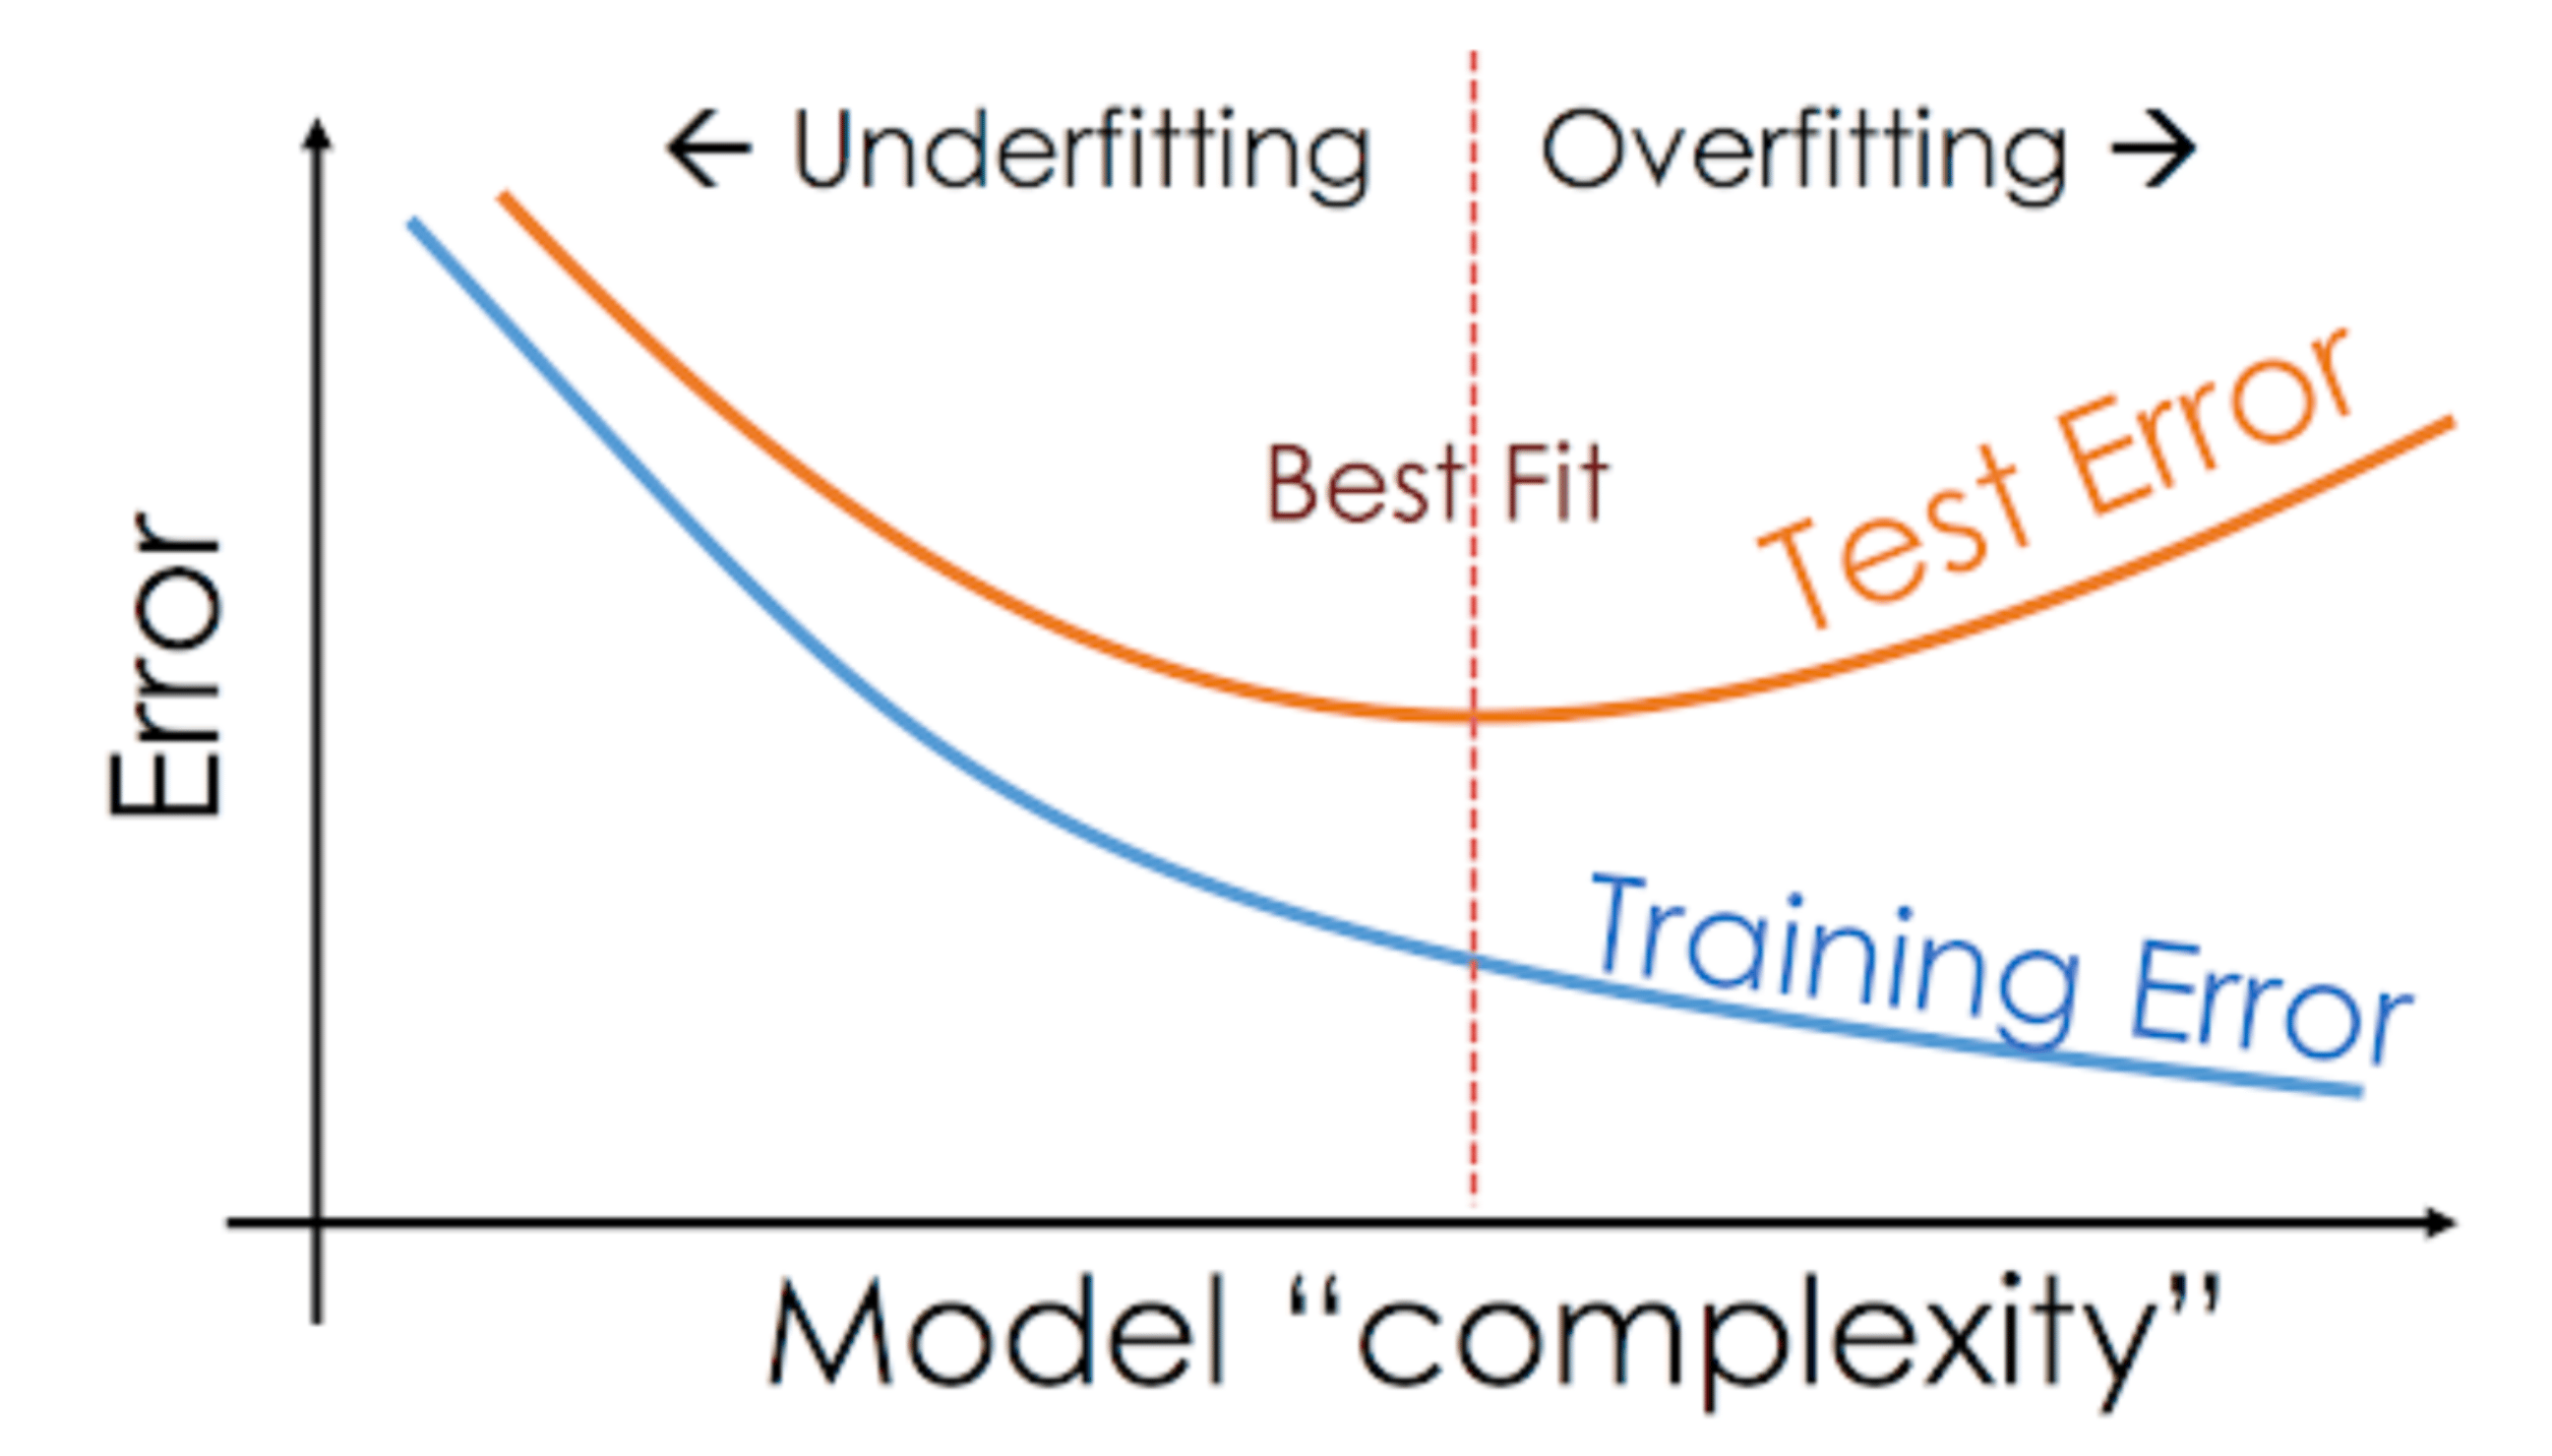

#5. Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results?

Yes, we performed hyperparameter tuning and cross-validation for our SVR model. We did feature expansion for the previous milestone (4) and determined that other stats (from the dataset) were already represented and more likely to cause overfitting than model improvement, so we decided not to do feature expansion this milestone.   

For the SVR model, we used GridSearchCV to search for the best hyperparameters. We defined a parameter grid with different values for the kernel, regularization parameter (C), epsilon, kernel coefficient (gamma), and degree (for polynomial kernel function). We used 5-fold cross-validation (cv=5) to evaluate the model's performance for each combination of hyperparameters. GridSearchCV then selected the best combination of hyperparameters based on the model's performance. After finding the best hyperparameters for the SVR model, we fit the model using the best parameters.

The results of hyperparameter tuning showed that the best parameters for the SVR model were found through GridSearchCV, in this case values of {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'poly'} and score of 29. **Measuring via testing MSE, We observe that the SVR model is better than our DNN models it roughly has the same performance as manual-tuned DNN model, and is not as performant as the elastic net model.**

# 7. Conclusion section: What is the conclusion of your 3rd model? What can be done to possibly improve it? How did it perform compared with your other models and why?

In conclusion, our third model, a SVR model, provided a new way to try to model the NBA data. Although it was not as performant as the elastic net model from the previous milestone, it was nevertheless an interesting exploration. While the elastic net model had test data MSE of 20 and R^2 value of 0.91, the SVR model had test data MSE of 25 and R^2 value of 0.88. However, compared to the DNN models, we generally did better or the same, with lower error and a higher R^2 coeffecient between predicted and mean, indicating a higher correlation (and therefore better prediction) of the two.

Another model part of this milestone was the Ensemble model we created by averaging all the predictions of other models we've created (linear regression, elastic net, DNN models, and SVR model) and returning this averaged result as a prediction. This model was as performant as the elastic net model, or even a slightly better, with testing MSE of 20 and R^2 of 0.91.

To further improve our models, we can (continue to) explore several avenues:

Regularization Techniques: Investigate different regularization techniques for the DNN models, such as L1 and L2 regularization, dropout, or early stopping, to mitigate overfitting and enhance generalization.

Hyperparameter Fine-tuning: Conduct more extensive hyperparameter tuning (with more potential values for each hyperparameter and more SVR hyperparameters being tuned) for the SVR models to find the optimal combination of hyperparameters that minimizes the error metrics.

Feature Selection and Engineering: Revisiting feature importance and considering other potentially relevant features or engineering new features based on domain knowledge to improve the models' predictive power.

Data Augmentation: Collect more diverse and representative data to increase the models' exposure to different scenarios and improve their generalization ability.

Compared to our first linear regression model, this final SVR model did not achieve a significant performance improvement. In fact, it unfortunately overfitted and did worse on testing data. The Elastic Net model from the previous milestone remains our best model.